# Import Libraries and Set Config

In [9]:

import pandas as pd
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, helpers

# Elasticsearch configuration
EXCEL_PATH = "data/crime/crime_data.xlsx"
SHEET_NAME = "Table 03"
INDEX_NAME = "crime_incidents"
ES_HOST = "http://localhost:9200"

es = Elasticsearch(ES_HOST)

#  Load and Filter Excel Data

In [10]:
def load_filtered_data():
    usecols = ["Year", "Postcode", "Offence Division", "Incidents Recorded"]
    df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME, usecols=usecols)
    df.columns = [col.strip().replace(" ", "_").lower() for col in df.columns]
    df = df.dropna(subset=["year", "postcode", "offence_division", "incidents_recorded"])
    df["year"] = df["year"].astype(int)
    df["postcode"] = df["postcode"].astype(int)
    df["incidents_recorded"] = df["incidents_recorded"].astype(int)
    df = df[df["year"] >= 2019]
    return df

df = load_filtered_data()



# Upload to Elasticsearch

In [11]:
def upload_to_elasticsearch(df):
    actions = [
        {
            "_index": INDEX_NAME,
            "_source": row.to_dict()
        }
        for _, row in df.iterrows()
    ]
    if es.indices.exists(index=INDEX_NAME):
        es.indices.delete(index=INDEX_NAME)
    helpers.bulk(es, actions)
    print(f"Uploaded {len(actions)} records to index '{INDEX_NAME}'")

upload_to_elasticsearch(df)

Uploaded 204188 records to index 'crime_incidents'


# Show Top 10 Crime Incident Number Postcodes and their Most Committed Offence Divisionas Chart

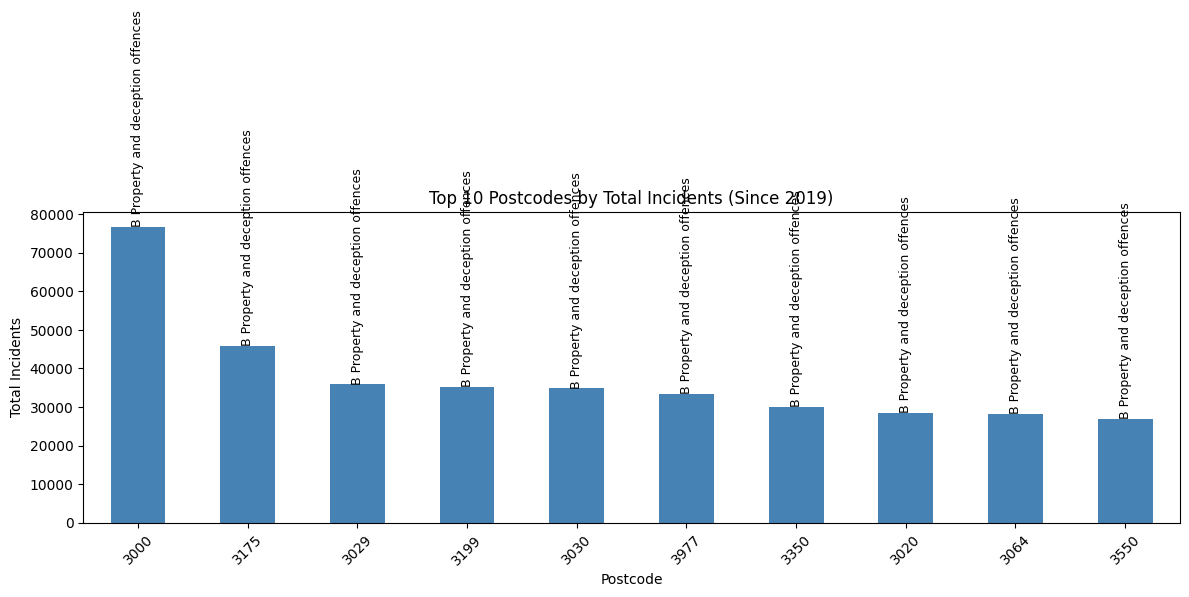

In [12]:
def show_top_10_postcodes_with_crime_type(df):
    # Step 1: Get top 10 postcodes by total incidents
    top_postcodes = (
        df.groupby("postcode")["incidents_recorded"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )

    # Step 2: Get the most committed offence division for each of those postcodes
    crime_labels = {}
    for postcode in top_postcodes.index:
        subset = df[df["postcode"] == postcode]
        top_crime = (
            subset.groupby("offence_division")["incidents_recorded"]
            .sum()
            .sort_values(ascending=False)
            .idxmax()
        )
        crime_labels[postcode] = top_crime

    # Step 3: Plot the bar chart
    plt.figure(figsize=(12, 6))
    ax = top_postcodes.plot(kind="bar", color="steelblue")
    plt.title("Top 10 Postcodes by Total Incidents (Since 2019)")
    plt.xlabel("Postcode")
    plt.ylabel("Total Incidents")
    plt.xticks(rotation=45)

    # Step 4: Annotate each bar with the top crime type
    for i, (postcode, total) in enumerate(top_postcodes.items()):
        crime_type = crime_labels[postcode]
        ax.text(i, total + 5, crime_type, ha='center', va='bottom', fontsize=9, rotation=90)

    plt.tight_layout()
    plt.show()

show_top_10_postcodes_with_crime_type(df)

# Query by Postcode

In [13]:
def query_incident_by_postcode(postcode):
    query = {
        "size": 0,
        "query": {
            "term": {"postcode": postcode}
        },
        "aggs": {
            "total_incidents": {
                "sum": {"field": "incidents_recorded"}
            },
            "top_offence_division": {
                "terms": {
                    "field": "offence_division.keyword",
                    "size": 1
                }
            }
        }
    }

    result = es.search(index=INDEX_NAME, body=query)
    total = result['aggregations']['total_incidents']['value']
    buckets = result['aggregations']['top_offence_division']['buckets']
    top_offence = buckets[0]['key'] if buckets else "No data"

    print(f"Postcode: {postcode}")
    print(f"Total incidents (since 2019): {int(total)}")
    print(f"Most common offence division: {top_offence}")


In [14]:
query_incident_by_postcode(3000)

Postcode: 3000
Total incidents (since 2019): 76762
Most common offence division: B Property and deception offences
